# Chapter 14 - Deep Computer Vision Using Convolutional Neural Networks

## Convolutional layers

Convolutional layers perform the convolution operation to images. 

- The operation can be carried out with or without padding.
- There is a receptive field (region of the image) responsible for applying filters to the image that slides over the image horizontally and vertically.
- The shift from on region of the image to another is called stride.
- These filters define feature maps, and they can also be stacked to create volumes from the image.

### TensorFlow Implementation

In TensorFlow, each input image is typically represented as a 3D tensor of shape [height, width, channels]. A mini-batch is represented as a 4D tensor of shape [mini-batch size, height, width, channels]. The weights of a convolutional layer are represented as a 4D tensor of shape [$f_h$,$f_w$,$f_{n^{'}}$,$f_n$]. The bias terms of a convolutional layer are simply represented as a 1D tensor of shape [$f_n$]. 

Let’s look at a simple example. The following code loads two sample images, using Scikit-Learn’s `load_sample_image()` (which loads two color images, one of a Chinese temple, and the other of a flower), then it creates two filters and applies them to both images, and finally it displays one of the resulting feature maps:

In [1]:
from sklearn.datasets import load_sample_image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2022-02-12 10:12:09.517288: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-12 10:12:09.517309: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

In [3]:
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

In [4]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

2022-02-12 10:12:11.725382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-12 10:12:11.725400: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-12 10:12:11.725415: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BRSPOBITANL1634): /proc/driver/nvidia/version does not exist
2022-02-12 10:12:11.725974: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


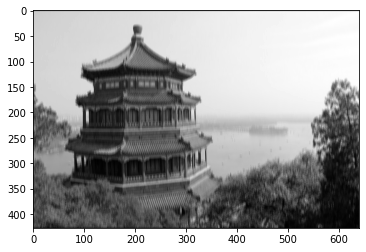

In [5]:
plt.imshow(outputs[0, :, :, 0], cmap="gray") # plot 1st image's 1st feature map
plt.show()

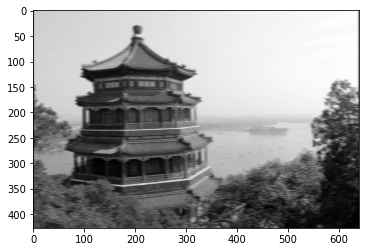

In [6]:
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

### Implementation

Convolutional Layers:

```python
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="same", activation="relu")
```

Pooling layers:

```python
max_pool = keras.layers.MaxPool2D(pool_size=2)
```

## CNN Architectures

In [7]:
# load the fashion mnist dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [8]:
# split into training/validation sets
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [9]:
X_train.shape

(55000, 28, 28)

In [10]:
X_mean = X_train.mean(axis=0, keepdims=True)

In [11]:
X_mean.shape

(1, 28, 28)

In [12]:
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

In [13]:
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [14]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [15]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=8, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/8
1719/1719 [==============================] - 217s 125ms/step - loss: 0.6964 - accuracy: 0.7584 - val_loss: 0.3634 - val_accuracy: 0.8700
Epoch 2/8
1719/1719 [==============================] - 217s 127ms/step - loss: 0.4225 - accuracy: 0.8603 - val_loss: 0.3036 - val_accuracy: 0.8858
Epoch 3/8
1719/1719 [==============================] - 216s 126ms/step - loss: 0.3681 - accuracy: 0.8765 - val_loss: 0.2925 - val_accuracy: 0.8934
Epoch 4/8
1719/1719 [==============================] - 216s 125ms/step - loss: 0.3310 - accuracy: 0.8881 - val_loss: 0.2735 - val_accuracy: 0.8980
Epoch 5/8
1719/1719 [==============================] - 214s 124ms/step - loss: 0.3138 - accuracy: 0.8946 - val_loss: 0.2752 - val_accuracy: 0.8988
Epoch 6/8
1719/1719 [==============================] - 214s 124ms/step - loss: 0.2952 - accuracy: 0.8990 - val_loss: 0.2776 - val_accuracy: 0.9064
Epoch 7/8
1719/1719 [==============================] - 214s 125ms/step - loss: 0.2803 - accuracy: 0.9032 - val_loss: 0

## LeNet-5